# Decision Tree Regressor Model

### Import dependencies for data manipulation and visualization

In [111]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


Read in data from pkl file

In [112]:
df = pd.read_pickle('../../data/ava_st1_ns4_56.pkl')
df.head


<bound method NDFrame.head of        apcp_sf1_1  apcp_sf2_1 apcp_sf3_1  apcp_sf4_1  apcp_sf5_1  dlwrf_s1_1  \
V1       0.000000         0.0          1    0.000000    0.000000  256.492673   
V2       0.000000         0.0          1    0.017273    0.139091  257.998596   
V3       0.000000         0.0          1    0.000000    0.000000  219.280002   
V4       0.004545         0.0          1    0.000000    0.000000  267.863045   
V5       0.000000         0.0          1    0.000000    0.000000  238.162747   
...           ...         ...        ...         ...         ...         ...   
V4376    0.010909         0.0          1    0.000000    0.000000  278.168651   
V4377    0.000000         0.0          1    0.000000    0.000000  251.551092   
V4378    0.000000         0.0          1    0.000000    0.000000  269.446164   
V4379    0.000000         0.0          1    0.000000    0.000000  268.862049   
V4380    0.000000         0.0          1    0.000000    0.000000  269.112621   

       dl

Establish input and output columns

In [113]:
x = df.drop('energy', axis=1)
y = df['energy']


Import sklearn dependencies

In [114]:
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split


#### Standardize the data and scale it for easier processing.

In [115]:
preprocessor = ColumnTransformer(
    transformers = [
        ('STscaler', StandardScaler(), make_column_selector(dtype_include=np.float64)),
        ('MMscaler', MinMaxScaler(), make_column_selector(dtype_include=np.int64))
    ],
    remainder = 'passthrough'
)

preprocessor.fit(x)

X =  preprocessor.transform(x)



# Holdout Method
#### We will use holdout at first to get a baseline accuracy score and show improvements with cross validation and hyperparameter tuning.

First we will split the data into training and testing sets.

In [116]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


Importing the Decision Tree Regressor model from sklearn

In [117]:
from sklearn.tree import DecisionTreeRegressor

Now we create the DecisionTreeRegressor model, fit it to the training data and make a prediction on the test data that will be validated in subsequest cells.

In [118]:
tree = DecisionTreeRegressor(max_depth=5)
tree.fit(X_train, y_train)


DecisionTreeRegressor(max_depth=5)

In [119]:
y_pred = tree.predict(X_test)

#### Creating a Dummy regressor to see if the model is better than a trivial model.

In [120]:
from sklearn.dummy import DummyRegressor

In [121]:
dummy_regressor = DummyRegressor(strategy='mean')
dummy_regressor.fit(X_train, y_train)
y_pred_dummy = dummy_regressor.predict(X_test)

### Import dependencies for evaluation metrics and calculate mean squared error, r2 score, mean absolute error.

In [122]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

my_scores = []


In [123]:
mse_values = ["MSE"]
mse = mean_squared_error(y_test, y_pred)
mse_dummy = mean_squared_error(y_test, y_pred_dummy)
print("The model's mse: ", mse)
print("The dummy's mse: ", mse_dummy)
print("Relative error: ", mse/mse_dummy)

mse_values.append(mse)
mse_values.append(mse_dummy)

my_scores.append(mse_values)




The model's mse:  11518827047686.314
The dummy's mse:  64828773154235.16
Relative error:  0.17768078103655752


In [124]:
r2_values = ["R2"]
r2 = r2_score(y_test, y_pred)
r2_dummy = r2_score(y_test, y_pred_dummy)
print("The model's r2: ", r2)   
print("The dummy's r2: ", r2_dummy)

r2_values.append(r2)
r2_values.append(r2_dummy)

my_scores.append(r2_values)

The model's r2:  0.8221992027225945
The dummy's r2:  -0.0006754598901907993


In [125]:
mae_values = ["MAE"]
mae = mean_absolute_error(y_test, y_pred)
mae_dummy = mean_absolute_error(y_test, y_pred_dummy)
print("The model's mae: ", mae)
print("The dummy's mae: ", mae_dummy)
print("Relative error: ", mae/mae_dummy)

mae_values.append(mae)
mae_values.append(mae_dummy)

my_scores.append(mae_values)

The model's mae:  2365058.1169746807
The dummy's mae:  6889700.366610371
Relative error:  0.34327445188131656


#### Now we want to visualize these scores and determine how we'll compare it to other more sophisticated models.

In [126]:
print(f"{'Evaluation method':<25} {'Score':<20} {'Dummy Score':<20} {'Ratio (Score/Dummy Score)':<20}")

for item in my_scores:
    ratio = item[1]/item[2] if item[2] != 0 else 0
    print(f"{item[0]:<25} {item[1]:<20.3f} {item[2]:<20.3f} {ratio:<10.3f}")
    
    # print the ratio of the mse score over the mean value of y_test
print(f"Ratio of mae over mean value of y: {(mae)/np.mean(y):.3f}")

Evaluation method         Score                Dummy Score          Ratio (Score/Dummy Score)
MSE                       11518827047686.314   64828773154235.156   0.178     
R2                        0.822                -0.001               -1217.244 
MAE                       2365058.117          6889700.367          0.343     
Ratio of mae over mean value of y: 0.140


Given the bi-modal distribution of the data, we will need to consider the mean absolute error as the primary evaluation metric.


#### Let's also look at the residuals to see if there are any patterns.

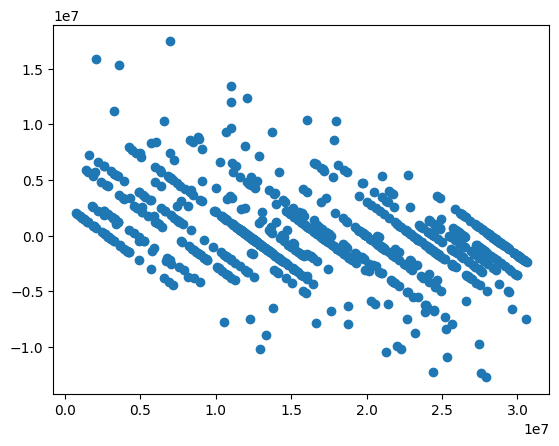

In [127]:
plt.scatter(y_test, y_pred - y_test)
plt.show()

Here, each stripe represents a leaf in the DecisionTreeRegressor. The residuals here appear relatively constant across the range of predicted values. 

# K-Fold Cross Validation

#### Hyper Parameter Tuning with Cross Validation

As we learned in class, while classification trees use measures like entropy or Gini impurity to evaluate the quality of a split, regression trees use variance (or equivalently, mean squared error) as the criterion for splitting. The key idea is to minimize the variance within each node. When constructing a decision tree for regression, at each step, the algorithm considers all possible splits on all features and selects the split that minimizes the variance of the target variable within each resulting node.

In [130]:
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import cross_val_score

# Define the cross validation scheme.
cv = KFold(n_splits=5, shuffle=True, random_state=56)


scores = cross_val_score(tree, X, y, cv=cv, scoring='neg_mean_absolute_error')
print(scores)
print(f"{'Average MAE scores without HPO: '}", -scores.mean())
print(f"{'Average MAE scores without HPO as a percentage of the mean y value: '}", f"{(-scores.mean()/np.mean(y)*100):.2f}", '%')


# Define the search space

param_grid = {
    'max_depth': [1,2,3,4,5,6,7,8,9,11,13,15],  # Add more values if needed
    'min_samples_split': [2, 5, 10, 20]  # Add more values if needed
}


# TODO - think about iterating over the grid and storing results to be able to plot the results. Have to put after fit func.
# print( pd.DataFrame(better_knn.cv_results_)[['mean_test_score', 'std_test_score', 'params']].sort_values(by='mean_test_score', ascending=False).head(5) )


better_tree = GridSearchCV(tree, param_grid, cv=cv, n_jobs=-1, scoring='neg_mean_absolute_error', refit=True)

#get the scores from the cross validation with HPO


better_tree.fit(X_train, y_train) 
better_scores = cross_val_score(better_tree, X_train, y_train, cv=cv, scoring='neg_mean_absolute_error')

print(f"{'Scores from CV with HPO'}", better_scores)
print(f"{'Average MAE scores with HPO: '}", -better_scores.mean())
print(f"{'Average MAE scores with HPO as a percentage of the mean y value: '}", f"{(-better_scores.mean()/np.mean(y)*100):.2f}", '%')



print(f"{'The best parameters when using negative mean absolute error scoring is: '}", better_tree.best_params_)
print(f"{'The best MAE score attained was: '}", -better_tree.best_score_)

print(f"{'HPO leads to a '}", f"{(1-(-better_scores.mean()/np.mean(y))/(-scores.mean()/np.mean(y)))*100:.2f}", '%', " improvement in MAE score over the model without HPO")


[-2540213.57880558 -2487791.66625811 -2519381.57228643 -2564253.77476701
 -2664540.81996241]
Average MAE scores without HPO:  2555236.282415907
Average MAE scores without HPO as a percentage of the mean y value:  15.14 %
Scores from CV with HPO [-2512176.51760625 -2729633.71705624 -2427090.07518168 -2833353.58804047
 -2572405.69606868]
Average MAE scores with HPO:  2614931.9187906613
Average MAE scores with HPO as a percentage of the mean y value:  15.50 %
The best parameters when using negative mean absolute error scoring is:  {'max_depth': 7, 'min_samples_split': 20}
The best MAE score attained was:  2587140.137956417
HPO leads to a  -2.34 %  improvement in MAE score over the model without HPO


### Now let's use this new model to predict values of the test data and evaluate the model.

In [131]:
better_predictions = better_tree.predict(X_test)


my_scores = []


mse_values = ["MSE"]
mse = mean_squared_error(y_test, y_pred)
mse_dummy = mean_squared_error(y_test, y_pred_dummy)

mse_values.append(mse)
mse_values.append(mse_dummy)

my_scores.append(mse_values)



r2_values = ["R2"]
r2 = r2_score(y_test, y_pred)
r2_dummy = r2_score(y_test, y_pred_dummy)

r2_values.append(r2)
r2_values.append(r2_dummy)

my_scores.append(r2_values)



mae_values = ["MAE"]
mae = mean_absolute_error(y_test, y_pred)
mae_dummy = mean_absolute_error(y_test, y_pred_dummy)

mae_values.append(mae)
mae_values.append(mae_dummy)

my_scores.append(mae_values)


print(f"{'Evaluation method':<25} {'Score':<20} {'Dummy Score':<20} {'Ratio (Score/Dummy Score)':<20}")

for item in my_scores:
    ratio = item[1]/item[2] if item[2] != 0 else 0
    print(f"{item[0]:<25} {item[1]:<20.3f} {item[2]:<20.3f} {ratio:<10.3f}")
    
    # print the ratio of the mse score over the mean value of y_test
print(f"Ratio of mae over mean value of y: {(mae)/np.mean(y):.3f}")



Evaluation method         Score                Dummy Score          Ratio (Score/Dummy Score)
MSE                       11518827047686.314   64828773154235.156   0.178     
R2                        0.822                -0.001               -1217.244 
MAE                       2365058.117          6889700.367          0.343     
Ratio of mae over mean value of y: 0.140
